In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [2]:
import pandas_datareader as web
from datetime import date

df = web.DataReader('GOOG', 'yahoo', start='2015-01-01', end='2020-02-01')
tsla_df = web.DataReader('TSLA', 'yahoo', start='2015-01-01', end='2020-02-01')
aaple_df = web.DataReader('AAPL', 'yahoo', start='2015-01-01', end='2020-02-01')
fb_df = web.DataReader('FB', 'yahoo', start='2015-01-01', end='2020-02-01')
msft_df = web.DataReader('MSFT', 'yahoo', start='2015-01-01', end='2020-02-01')
df.to_csv('google.csv')


tsla_df['Stock'] = 'TSLA'
aaple_df['Stock'] = 'AAPL'
fb_df['Stock'] = 'FB'
msft_df['Stock'] = 'MSFT'

In [3]:
all_stock_df = pd.concat([tsla_df,aaple_df,fb_df,msft_df])

all_stock_df.sample(10)

,High,Low,Open,Close,Volume,Adj Close,Stock
Date,,,,,,,
2016-06-17,43.998001,42.900002,43.562000,43.094002,15563000.0,43.094002,TSLA
2015-11-19,29.937500,29.190001,29.410000,29.695000,173183200.0,27.470516,AAPL
2016-03-28,54.290001,53.330002,54.209999,53.540001,17025100.0,49.094669,MSFT
2016-09-09,57.520000,56.209999,56.790001,56.209999,35113900.0,52.226990,MSFT
2018-12-27,101.190002,96.400002,99.300003,101.180000,49498500.0,98.433876,MSFT
2018-02-26,71.800003,70.472000,70.699997,71.484001,21700000.0,71.484001,TSLA
2015-01-15,76.570000,73.540001,76.400002,74.050003,34134000.0,74.050003,FB
2016-01-05,45.377998,44.000000,45.271999,44.686001,15934000.0,44.686001,TSLA
2017-12-18,181.300003,179.750000,181.009995,180.820007,17265400.0,180.820007,FB


In [4]:
all_stock_df.to_csv('all_stocks.csv')

In [5]:
df["Date"]=pd.to_datetime(df.index,format="%Y-%m-%d")
df.index=df['Date']

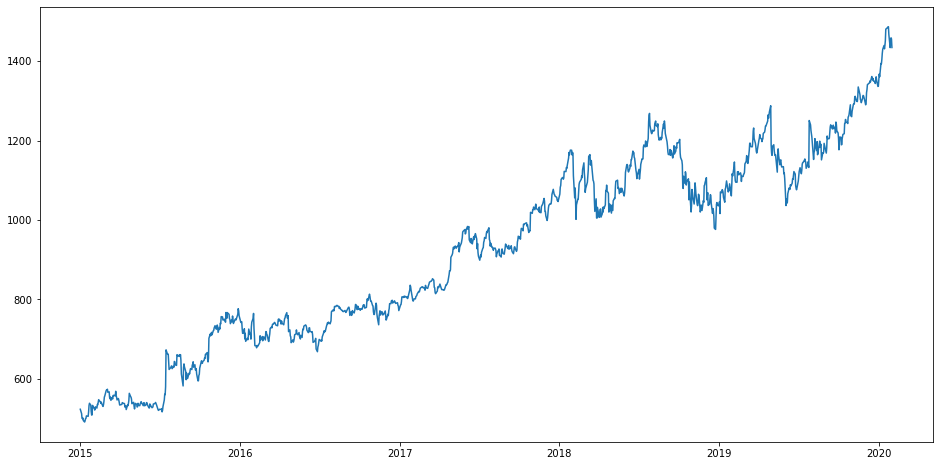

In [6]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"])

In [7]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [8]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

In [9]:
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [10]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [11]:
final_dataset=new_dataset.values

In [12]:
final_dataset.shape

(1279, 1)

In [13]:
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

In [14]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

In [15]:
x_train_data,y_train_data=[],[]

In [16]:
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

In [17]:
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [18]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [19]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 31s - loss: 0.0021


In [20]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [21]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

In [22]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

In [23]:
lstm_model.save("saved_lstm_model_for_goog.h5")

<ipython-input-24-eb292387a2e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


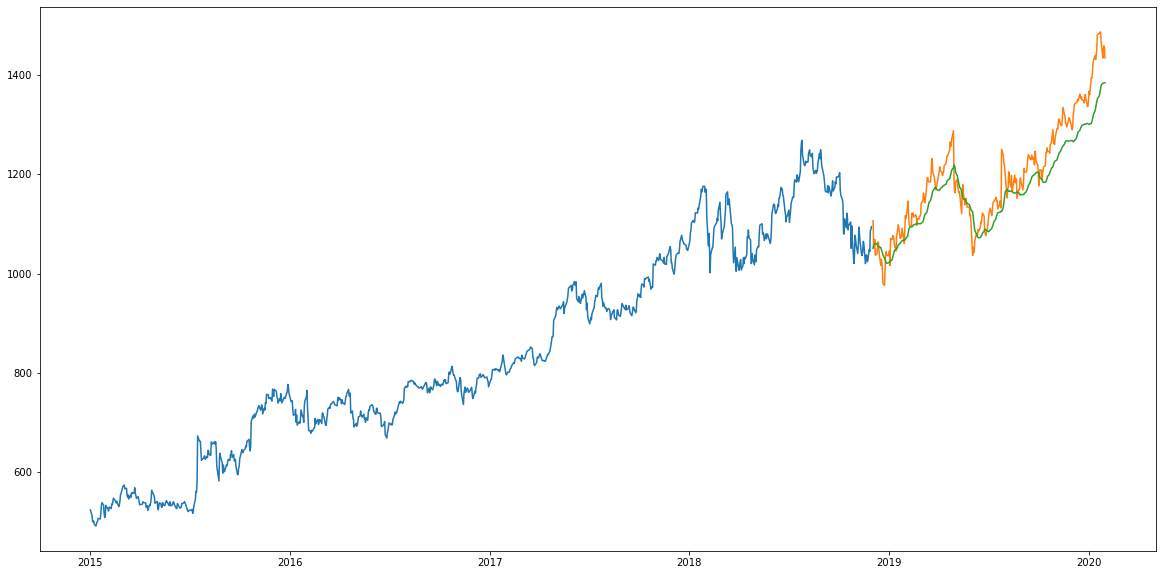

In [24]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])